In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.nn.init import xavier_uniform_
import torch.optim as optim
from skimage import color


In [65]:
batch_size = 64
val_size = 5000
learning_rate = 1e-3
use_gpu = True

In [66]:
# Converts the PIL image to a PyTorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))

img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

In [67]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
dataset = CIFAR10('./data/CIFAR10', transform=img_transform, target_transform=None, download=True)
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])
test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [68]:
# ColorizationNet
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

        # Pass input through ResNet-gray to extract features
        midlevel_features = self.midlevel_resnet(input)
        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_


class ImageClassifierRandom(nn.Module):
    def __init__(self, backbone):
        super(ImageClassifierRandom, self).__init__()
        self.backbone = backbone
        self.fc = nn.Linear(128, 10)  # Modify output size according to the number of classes (10 for CIFAR-10)
        # Initialize the parameters using xavier_uniform_
        self._initialize_parameters()

    def forward(self, input): #x is the input or batch of images
        features = self.backbone(input)
        features = F.adaptive_avg_pool2d(features, 1)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output #These outputs are logits which are a measure of the model's confidence for each class


    def _initialize_parameters(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(module.weight.data) #It comes from the pytorch.nn.init library and is used to generate random parameters (changes the weight of each module)
                if module.bias is not None:
                    module.bias.data.zero_() #If the model has bias, it sets it to zero 


# Image Classifier with Pretrained Initialization
class ImageClassifierPretrained(nn.Module):
    def __init__(self, backbone):
        super(ImageClassifierPretrained, self).__init__()
        self.backbone = backbone
        self.fc = nn.Linear(128, 10)  # Modify output size according to the number of classes (10 for CIFAR-10)

    def forward(self, input):
        features = self.backbone(input)
        features = F.adaptive_avg_pool2d(features, 1)
        features = features.view(features.size(0), -1)
        output = self.fc(features)

        return output #These outputs are logits which are a measure of the model's confidence for each class


In [69]:

# Initialize ColorizationNet model
colorization_model = ColorizationNet()
colorization_model.load_state_dict(torch.load('../input/models/colorization_model.pth'))  # Load pre-trained colorization model

# Create Image Classifier models
classifier_random = ImageClassifierRandom(colorization_model.midlevel_resnet)
classifier_pretrained = ImageClassifierPretrained(colorization_model.midlevel_resnet)




In [70]:

# Set device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

# Move models to device
classifier_random = classifier_random.to(device)
classifier_pretrained = classifier_pretrained.to(device)


In [71]:

# Set training parameters
num_epochs = 50  # Modify as desired
learning_rate = 0.001  # Modify as desired

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_random = torch.optim.Adam(classifier_random.parameters(), lr=learning_rate)
optimizer_pretrained = torch.optim.Adam(classifier_pretrained.parameters(), lr=learning_rate)




In [72]:
print('\nTraining with Random Initialization...')
classifier_random.train()  # Set the model to training mode

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    for lab_batch, labels in train_dataloader:
        lab_batch = lab_batch.to(device)
        labels = labels.to(device)
        
        optimizer_random.zero_grad()
        outputs = classifier_random(lab_batch[:, 0:1, :, :])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_random.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    accuracy = 100.0 * train_correct / train_total
    train_loss /= len(train_dataloader)
    
    # Validation
    classifier_random.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for val_batch, val_labels in val_dataloader:
            val_batch = val_batch.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = classifier_random(val_batch[:, 0:1, :, :])
            val_loss += criterion(val_outputs, val_labels).item()
            
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    val_accuracy = 100.0 * val_correct / val_total
    val_loss /= len(val_dataloader)

    print('Epoch [%d/%d] - Training Loss: %.4f - Training Accuracy: %.2f%% - Validation Loss: %.4f - Validation Accuracy: %.2f%%' % (epoch+1, num_epochs, train_loss, accuracy, val_loss, val_accuracy))

    classifier_random.train()  # Set the model back to training mode



Training with Random Initialization...
Epoch [1/10] - Training Loss: 1.3885 - Training Accuracy: 50.46% - Validation Loss: 1.2549 - Validation Accuracy: 55.74%
Epoch [2/10] - Training Loss: 0.9955 - Training Accuracy: 65.02% - Validation Loss: 1.1959 - Validation Accuracy: 58.08%
Epoch [3/10] - Training Loss: 0.8287 - Training Accuracy: 71.19% - Validation Loss: 1.1848 - Validation Accuracy: 60.60%
Epoch [4/10] - Training Loss: 0.7090 - Training Accuracy: 75.54% - Validation Loss: 1.1975 - Validation Accuracy: 61.18%
Epoch [5/10] - Training Loss: 0.6087 - Training Accuracy: 78.73% - Validation Loss: 0.8565 - Validation Accuracy: 71.14%
Epoch [6/10] - Training Loss: 0.5195 - Training Accuracy: 81.89% - Validation Loss: 1.0848 - Validation Accuracy: 66.00%
Epoch [7/10] - Training Loss: 0.4374 - Training Accuracy: 84.70% - Validation Loss: 0.8613 - Validation Accuracy: 71.50%
Epoch [8/10] - Training Loss: 0.3536 - Training Accuracy: 87.81% - Validation Loss: 1.5020 - Validation Accuracy:

In [74]:
print('\nTraining with Pretrained Initialization...')
classifier_pretrained.train()  # Set the model to training mode

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    for lab_batch, labels in train_dataloader:
        lab_batch = lab_batch.to(device)
        labels = labels.to(device)
        
        optimizer_random.zero_grad()
        outputs = classifier_pretrained(lab_batch[:, 0:1, :, :])

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_random.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    accuracy = 100.0 * train_correct / train_total
    train_loss /= len(train_dataloader)
    
    # Validation
    classifier_random.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for val_batch, val_labels in val_dataloader:
            val_batch = val_batch.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = classifier_pretrained(val_batch[:, 0:1, :, :])
            val_loss += criterion(val_outputs, val_labels).item()
            
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    val_accuracy = 100.0 * val_correct / val_total
    val_loss /= len(val_dataloader)

    print('Epoch [%d/%d] - Training Loss: %.4f - Training Accuracy: %.2f%% - Validation Loss: %.4f - Validation Accuracy: %.2f%%' % (epoch+1, num_epochs, train_loss, accuracy, val_loss, val_accuracy))

    classifier_pretrained.train()  # Set the model back to training mode



Training with Pretrained Initialization...
Epoch [1/10] - Training Loss: 0.2036 - Training Accuracy: 94.81% - Validation Loss: 0.8228 - Validation Accuracy: 73.90%
Epoch [2/10] - Training Loss: 0.1325 - Training Accuracy: 96.56% - Validation Loss: 0.9448 - Validation Accuracy: 71.76%
Epoch [3/10] - Training Loss: 0.1250 - Training Accuracy: 96.47% - Validation Loss: 1.0124 - Validation Accuracy: 70.38%
Epoch [4/10] - Training Loss: 0.1151 - Training Accuracy: 96.52% - Validation Loss: 1.0208 - Validation Accuracy: 72.14%
Epoch [5/10] - Training Loss: 0.0949 - Training Accuracy: 97.15% - Validation Loss: 1.0725 - Validation Accuracy: 71.92%
Epoch [6/10] - Training Loss: 0.0884 - Training Accuracy: 97.24% - Validation Loss: 1.0683 - Validation Accuracy: 73.00%
Epoch [7/10] - Training Loss: 0.0785 - Training Accuracy: 97.55% - Validation Loss: 1.1286 - Validation Accuracy: 72.36%
Epoch [8/10] - Training Loss: 0.0686 - Training Accuracy: 97.92% - Validation Loss: 1.2648 - Validation Accur

In [ ]:
print(lab_batch[:, 0:1, :, :].shape)
print(labels.shape)

In [75]:
# Evaluation
classifier_random.eval()
classifier_pretrained.eval()

test_loss_random = 0.0
test_loss_pretrained = 0.0
correct_random = 0
correct_pretrained = 0
total = 0

with torch.no_grad():
    for lab_batch, labels in test_dataloader:
        lab_batch = lab_batch.to(device)
        labels = labels.to(device)

        outputs_random = classifier_random(lab_batch[:, 0:1, :, :])
        loss_random = criterion(outputs_random, labels)

        outputs_pretrained = classifier_pretrained(lab_batch[:, 0:1, :, :])
        loss_pretrained = criterion(outputs_pretrained, labels)

        test_loss_random += loss_random.item()
        test_loss_pretrained += loss_pretrained.item()

        _, predicted_random = outputs_random.max(1)
        _, predicted_pretrained = outputs_pretrained.max(1)

        total += labels.size(0)
        correct_random += predicted_random.eq(labels).sum().item()
        correct_pretrained += predicted_pretrained.eq(labels).sum().item()

test_accuracy_random = 100.0 * correct_random / total
test_accuracy_pretrained = 100.0 * correct_pretrained / total

print('\nTest Results:')
print('Random Initialization - Loss: %.4f - Accuracy: %.2f%%' % (test_loss_random, test_accuracy_random))
print('Pretrained Initialization - Loss: %.4f - Accuracy: %.2f%%' % (test_loss_pretrained, test_accuracy_pretrained))


Test Results:
Random Initialization - Loss: 269.2717 - Accuracy: 70.35%
Pretrained Initialization - Loss: 184.5458 - Accuracy: 73.48%


In [76]:
import matplotlib.pyplot as plt

# Training results
train_loss_random_values = [1.3885, 0.9955, 0.8287, 0.7090, 0.6087, 0.5195, 0.4374, 0.3536, 0.2821, 0.2295]
train_accuracy_random_values = [50.46, 65.02, 71.19, 75.54, 78.73, 81.89, 84.70, 87.81, 90.25, 91.99]
val_loss_random_values = [1.2549, 1.1959, 1.1848, 1.1975, 0.8565, 1.0848, 0.8613, 1.5020, 1.2120, 1.0279]
val_accuracy_random_values = [55.74, 58.08, 60.60, 61.18, 71.14, 66.00, 71.50, 60.38, 66.38, 71.20]

train_loss_pretrained_values = [0.2036, 0.1325, 0.1250, 0.1151, 0.0949, 0.0884, 0.0785, 0.0686, 0.0741, 0.0576]
train_accuracy_pretrained_values = [94.81, 96.56, 96.47, 96.52, 97.15, 97.24, 97.55, 97.92, 97.68, 98.18]
val_loss_pretrained_values = [0.8228, 0.9448, 1.0124, 1.0208, 1.0725, 1.0683, 1.1286, 1.2648, 1.1784, 1.1268]
val_accuracy_pretrained_values = [73.90, 71.76, 70.38, 72.14, 71.92, 73.00, 72.36, 71.44, 73.02, 73.44]

# Test results
test_loss_random = 269.2717
test_accuracy_random = 70.35
test_loss_pretrained = 184.5458
test_accuracy_pretrained = 73.48

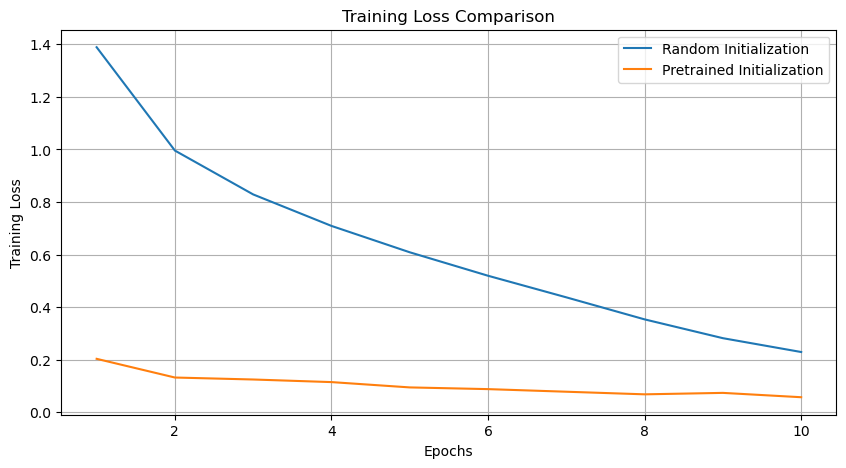

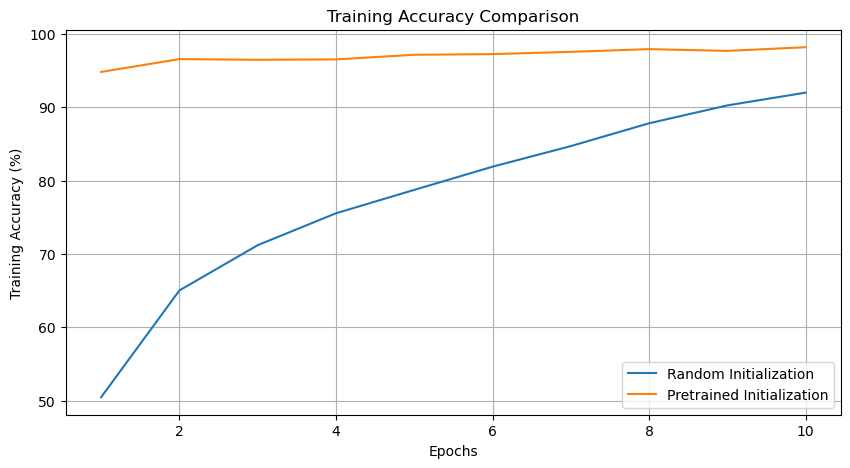

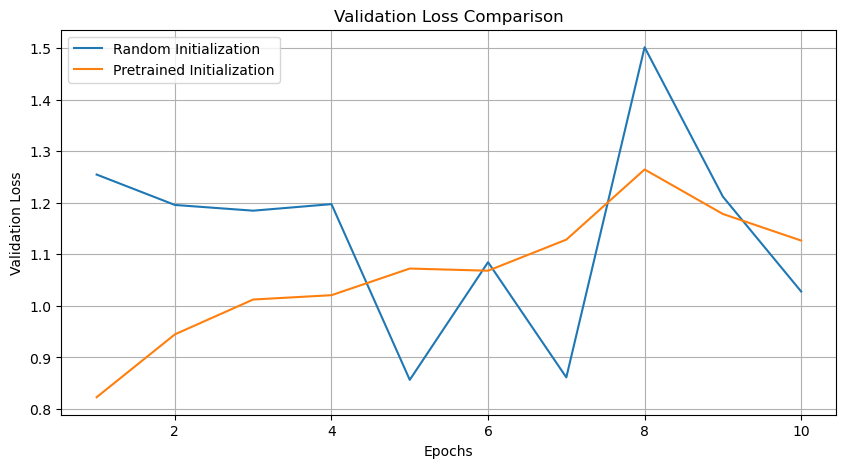

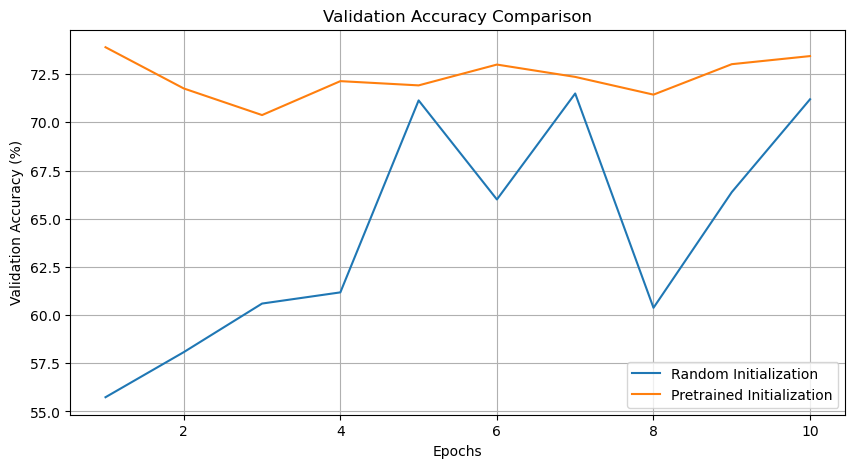

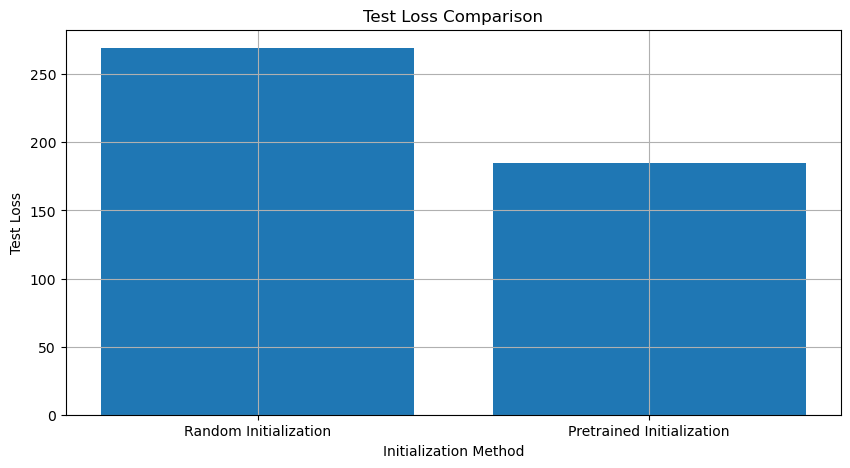

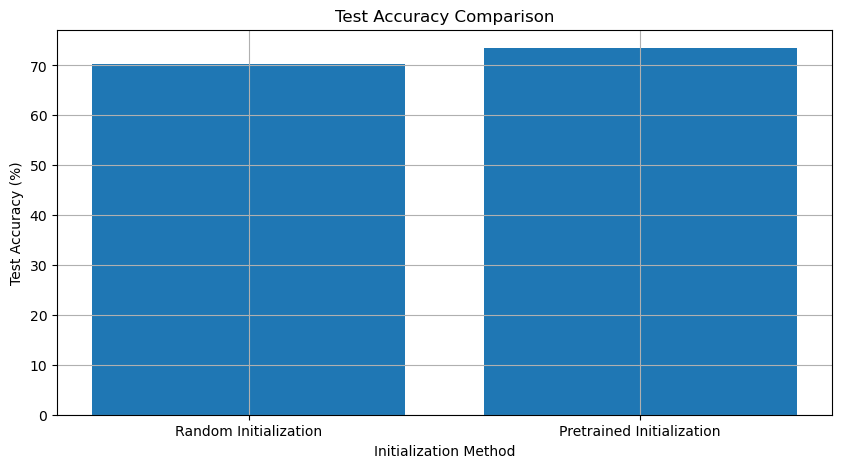

In [77]:
epochs = range(1, 11)

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_random_values, label='Random Initialization')
plt.plot(epochs, train_loss_pretrained_values, label='Pretrained Initialization')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_random_values, label='Random Initialization')
plt.plot(epochs, train_accuracy_pretrained_values, label='Pretrained Initialization')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss_random_values, label='Random Initialization')
plt.plot(epochs, val_loss_pretrained_values, label='Pretrained Initialization')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy_random_values, label='Random Initialization')
plt.plot(epochs, val_accuracy_pretrained_values, label='Pretrained Initialization')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the test results
labels = ['Random Initialization', 'Pretrained Initialization']
test_loss_values = [test_loss_random, test_loss_pretrained]
test_accuracy_values = [test_accuracy_random, test_accuracy_pretrained]

plt.figure(figsize=(10, 5))
plt.bar(labels, test_loss_values)
plt.xlabel('Initialization Method')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(labels, test_accuracy_values)
plt.xlabel('Initialization Method')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.grid(True)
plt.show()